# Importando bibliotecas e base

In [1]:
import pandas as pd
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
import pymc as pm
import pytensor.tensor as tt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pymc as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import plotly.express as px
import numpy as np
from scipy.stats import mode

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os

pasta_datasets = '/content/drive/My Drive/ANTAQ'

arquivos = os.listdir(pasta_datasets)
print(arquivos)

['df_cargas_santos_filtrado.csv', 'Instalacao_Origem.txt', '2019TemposAtracacao.txt', 'MercadoriaConteinerizada.txt', '2018TemposAtracacao.txt', 'cafe_jan2010_ate_jul2024.db', 'Instalacao_Destino.txt', '2022Atracacao.txt', '2018Atracacao.txt', '2019Atracacao.txt', '2020Atracacao.txt', '2020TemposAtracacao.txt', '2021TemposAtracacao.txt', '2021Atracacao.txt', '2018Carga_Conteinerizada.txt', '2019Carga_Conteinerizada.txt', '2022Carga_Conteinerizada.txt', '2020Carga_Conteinerizada.txt', '2021Carga_Conteinerizada.txt', '2023Atracacao.txt', '2019Carga.txt', '2022Carga.txt', 'df_cargas_brasil.csv', '2021Carga.txt', '2023Carga.txt', 'df_cargas_brasil2.csv', '2020Carga.txt', '2018Carga.txt', 'df_santos_coffee_no_duplicates.csv', 'df_santos_coffee.csv']


In [4]:
caminho_arquivo = f'{pasta_datasets}/df_santos_coffee.csv'
df_oficial = pd.read_csv(caminho_arquivo, encoding='latin-1')

<ipython-input-4-1e3644df3297>:2: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  df_oficial = pd.read_csv(caminho_arquivo, encoding='latin-1')


##Juntando com outra base para poder agrupar por Continentes

In [5]:
portos_mundiais = pd.read_excel('/content/drive/My Drive/Temporário/Relatorio Portos - 28_11_2024 21_37_46.xlsx')

In [6]:
portos_mundiais['Destino'] = portos_mundiais['Bigrama do Porto'].astype(str) + portos_mundiais['Trigrama do Porto'].astype(str)

In [7]:
df_oficial = pd.merge(df_oficial, portos_mundiais, on='Destino', how='left')

# Consistencia dos dados

In [8]:
print('quantidade de linhas e colunas:', df_oficial.shape)
print('=' * 40)
print('\n quantidade de NAs:\n', df_oficial.isnull().sum())
print('=' * 40)
print('\n colunas da base:\n', df_oficial.columns)
print('=' * 40)
print('\n quantidade de duplicatas:', df_oficial.duplicated().sum())
print('=' * 40)
print('\n tipos das colunas:', df_oficial.dtypes)
print('=' * 40)
print('\nQuantidade de destinos únicos (variável resposta):', df_oficial['Destino'].nunique())

quantidade de linhas e colunas: (2987573, 34)

 quantidade de NAs:
 IDCarga                             0
IDAtracacao                         0
Origem                              0
Destino                             0
CDMercadoria                        0
Tipo Operação da Carga              0
Carga Geral Acondicionamento        0
Tipo Navegação                      0
FlagAutorizacao                     0
FlagCabotagem                       0
FlagCabotagemMovimentacao           0
FlagLongoCurso                      0
FlagMCOperacaoCarga                 0
FlagOffshore                        0
FlagTransporteViaInterioir          0
STNaturezaCarga                     0
STSH2                               0
STSH4                               0
Natureza da Carga                   0
Sentido                             0
TEU                                 0
QTCarga                             0
VLPesoCargaBruta                    0
IDBerco                             0
Berço               

In [9]:
#dropando duplicatas
df_oficial.drop_duplicates(inplace=True)
#substituindo virgula por ponto para convertermos para float
df_oficial['VLPesoCargaBruta'] = df_oficial['VLPesoCargaBruta'].str.replace(',', '.').astype(float)
#dropando linhas NAs
df_oficial.dropna(inplace=True)

# Visualizando a ocorrência de importações por país

In [10]:
# Contando as ocorrências de cada país
ocorrencias_por_pais = df_oficial['País'].value_counts().reset_index()
ocorrencias_por_pais.columns = ['País', 'ocorrencias']

# Criando o mapa com Plotly
fig = px.choropleth(ocorrencias_por_pais,
                    locations='País',  # Coluna com os países
                    locationmode='country names',  # Usando os nomes dos países
                    color='ocorrencias',  # Coluna com as ocorrências
                    hover_name='País',  # Nome do país ao passar o mouse
                    color_continuous_scale='Viridis',  # Escala de cor (pode escolher outras, como 'Blues', 'YlOrRd', etc.)
                    title="Ocorrências por País")

# Exibindo o mapa
fig.show()

# Agrupando portos por continente
Como existem 494 portos destintos, ficaria inviavel criar um modelo para prever 494 categorias, por isso o agrupamento por continente

In [11]:
continentes = {
    'MÉXICO': 'América',
    'ESTADOS UNIDOS': 'América',
    'COLÔMBIA': 'América',
    'ARGENTINA': 'América',
    'BRASIL': 'América',
    'CHINA': 'Ásia',
    'CORÉIA DO SUL': 'Ásia',
    'HONG KONG': 'Ásia',
    'SINGAPURA': 'Ásia',
    'MALÁSIA': 'Ásia',
    'URUGUAI': 'América',
    'INDONÉSIA': 'Ásia',
    'VIETNÃ': 'Ásia',
    'AUSTRÁLIA': 'Oceania',
    'ITÁLIA': 'Europa',
    'CUBA': 'América',
    'REPÚBLICA DOMINICANA': 'América',
    'EQUADOR': 'América',
    'GUATEMALA': 'América',
    'CANADÁ': 'América',
    'COSTA RICA': 'América',
    'PANAMÁ': 'América',
    'PERU': 'América',
    'HOLANDA': 'Europa',
    'TURQUIA': 'Ásia',
    'ISRAEL': 'Ásia',
    'ANGOLA': 'África',
    'CONGO': 'África',
    'ÁFRICA DO SUL': 'África',
    'TAIWAN': 'Ásia',
    'CHIPRE': 'Ásia',
    'ALEMANHA': 'Europa',
    'FRANÇA': 'Europa',
    'ÍNDIA': 'Ásia',
    'PARAGUAI': 'América',
    'JAMAICA': 'América',
    'EMIRADOS ÁRABES UNIDOS': 'Ásia',
    'EGITO': 'África',
    'ESPANHA': 'Europa',
    'IRÃ': 'Ásia',
    'JORDÂNIA': 'Ásia',
    'KUWAIT': 'Ásia',
    'LIBANO': 'Ásia',
    'MARROCOS': 'África',
    'TUNISIA': 'África',
    'JAPÃO': 'Ásia',
    'BÉLGICA': 'Europa',
    'CHILE': 'América',
    'Reino Unido da Grã Bretanha e Irlanda': 'Europa',
    'GANA': 'África',
    'POLÔNIA': 'Europa',
    'PORTUGAL': 'Europa',
    'QATAR': 'Ásia',
    'ROMÊNIA': 'Europa',
    'ARÁBIA SAUDITA': 'Ásia',
    'SÍRIA': 'Ásia',
    'TAILÂNDIA': 'Ásia',
    'RÚSSIA': 'Ásia',
    'GRÉCIA': 'Europa',
    'MALTA': 'Europa',
    'LATVIA': 'Europa',
    'SUÉCIA': 'Europa',
    'LITUÂNIA': 'Europa',
    'OMÃ': 'Ásia',
    'ILHAS MAURICIO': 'África',
    'GEÓRGIA': 'Ásia',
    'FINLÂNDIA': 'Europa',
    'CROÁCIA': 'Europa',
    'LIBIA': 'África',
    'NICARÁGUA': 'América',
    'VENEZUELA': 'América',
    'BAHAMAS': 'América',
    'CABO VERDE': 'África',
    'TRINIDAD E TOBAGO': 'América',
    'BULGÁRIA': 'Europa',
    'ILHAS REUNIÃO': 'África',
    'COSTA DO MARFIM': 'África',
    'SRI LANKA': 'Ásia',
    'HONDURAS': 'América',
    'IRAQUE': 'Ásia',
    'PAQUISTÃO': 'Ásia',
    'FILIPINAS': 'Ásia',
    'NORUEGA': 'Europa',
    'GÂMBIA': 'África',
    'UCRÂNIA': 'Europa',
    'ARGÉLIA': 'África',
    'IRLANDA': 'Europa',
    'BENIN': 'África',
    'MONTENEGRO': 'Europa',
    'BELIZE': 'América',
    'GUIANA': 'América',
    'HAITI': 'América',
    'SURINAME': 'América',
    'ILHAS CAYMAN': 'América',
    'NIGÉRIA': 'África',
    'BANGLADESH': 'Ásia',
    'BARBADOS': 'América',
    'GRANADA': 'América',
    'ANTILHAS HOLANDESAS': 'América',
    'ÁUSTRIA': 'Europa',
    'DINAMARCA': 'Europa',
    'QUÊNIA': 'África',
    'ESLOVÁQUIA': 'Europa',
    'IEMEM': 'Ásia',
    'MYANMAR': 'Ásia',
    'MOÇAMBIQUE': 'África',
    'NOVA ZELÂNDIA': 'Oceania',
    'GUINÉ': 'África',
    'ESLOVÊNIA': 'Europa',
    'TOGO': 'África',
    'ALBÂNIA': 'Europa',
    'BAHRAIN': 'Ásia',
    'ANTIGUA E BARBUDA': 'América',
    'ESTÔNIA': 'Europa',
    'UGANDA': 'África',
    'REPÚBLICA DO CONGO': 'África',
    'SERRA LEOA': 'África',
    'ST VINCENT E GRENADINES': 'América',
    'LIBÉRIA': 'África',
    'SENEGAL': 'África',
    'PORTO RICO': 'América',
    'EL SALVADOR': 'América',
    'MADAGASCAR': 'África',
    'DJIBOUTI': 'África',
    'ARUBA': 'América',
    'TANZANIA': 'África',
    'CAMBOJA': 'Ásia',
    'SUDÃO': 'África',
    'PÁPUA NOVA GUINÉ': 'Oceania',
    'REPÚBLICA DE CAMARÕES': 'África',
    'GABÃO': 'África',
    'FIJI': 'Oceania',
    'GUINÉ EQUATORIAL': 'África',
    'SANTA LÚCIA': 'América',
    'Não Identificado': 'Desconhecido',
    'MAURITÂNIA': 'África',
    'ISLÂNDIA': 'Europa',
    'POLINÉSIA FRANCESA': 'Oceania',
    'GUINÉ BISSAL': 'África',
    'GUADALUPE': 'América',
    'ILHAS MALDIVAS': 'Ásia',
    'NOVA CALEDÔNIA': 'Oceania',
    'ILHAS COMOROS': 'África'
}


In [12]:
# Aplicar o mapeamento de continentes
df_oficial['Continente'] = df_oficial['País'].map(continentes)

In [13]:
df_oficial['Continente'].isna().sum()

1210

In [14]:
df_oficial['Continente'] = df_oficial['Continente'].fillna('Desconhecido')

# Preparando variáveis para o modelo

In [15]:
# Amostragem estratificada para garantir que a amostra seja heterogênea em relação a "Continente"
df_sampled = df_oficial.groupby('Continente', group_keys=False).apply(lambda x: x.sample(frac=0.0006, random_state=42))

<ipython-input-15-d15000882176>:2: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [16]:
Y = df_sampled['Continente']
X = df_sampled.drop(columns=['Continente'])

In [17]:
#transformando colunas nomimais para numéricas
label_encoder = LabelEncoder()

# Codificando as variáveis categóricas
categorical_columns = X.select_dtypes(include=['object']).columns
for col in categorical_columns:
    # Ensure all values are strings before encoding
    X[col] = X[col].astype(str)
    X[col] = label_encoder.fit_transform(X[col])

In [18]:
# Codificando a variável categórica (Continente) como variáveis numéricas
le = LabelEncoder()
Y_encoded = le.fit_transform(Y)

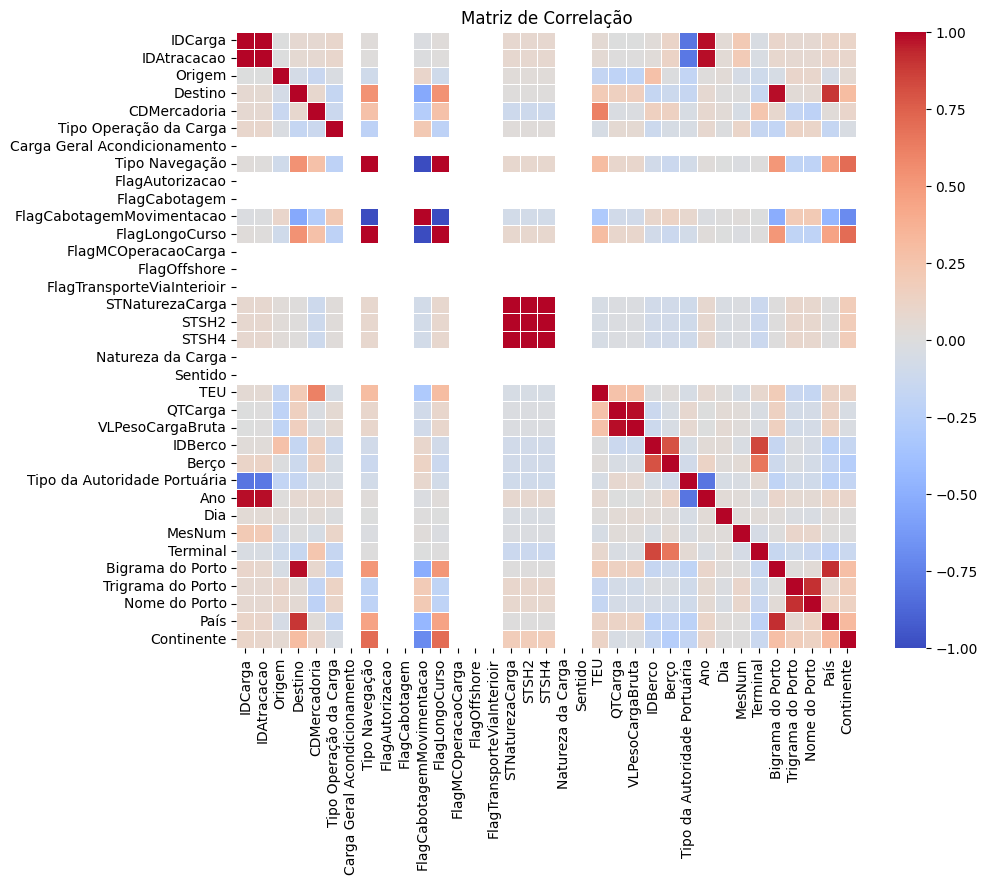

In [19]:
X_Y = pd.concat([X, Y], axis=1)
X_Y['Destino'] = label_encoder.fit_transform(X_Y['Destino'])
X_Y['Continente'] = label_encoder.fit_transform(X_Y['Continente'])
# Configurando o tamanho da figura
plt.figure(figsize=(10, 8))

# Plotando o heatmap
sns.heatmap(X_Y.corr(), annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Exibindo o gráfico
plt.title('Matriz de Correlação')
plt.show()


In [20]:
# selecionando variaveis que vao entrar no modelo
X = X[['País','Destino',
       'Tipo Navegação','Tipo da Autoridade Portuária']]

* Normalização/Padronização

Processos Gaussianos são sensíveis à escala das variáveis, portanto, é uma boa prática normalizar ou padronizar as variáveis numéricas.

In [21]:
# Normalizando as variáveis numéricas
scaler = StandardScaler()
X_normalizado = scaler.fit_transform(X)
X_normalizado = pd.DataFrame(X_normalizado, columns=X.columns)

#Modelo 1

In [22]:
with pm.Model() as model_p:
    l = pm.HalfNormal("l0", 1)
    cov = pm.gp.cov.Matern32(4, ls=l)
    gp = pm.gp.Latent(cov_func=cov)

    s = pm.HalfNormal("s0", sigma=1, shape=3)

    l1 = pm.HalfNormal("l1", 1)
    cov1 = pm.gp.cov.Matern32(4, ls=l1)
    gp1 = pm.gp.Latent(cov_func=cov1)

    l2 = pm.HalfNormal("l2", 1)
    cov2 = pm.gp.cov.Matern32(4, ls=l2)
    gp2 = pm.gp.Latent(cov_func=cov2)


    f = gp.prior("f", X=X_normalizado.values)
    g = gp1.prior("g", X=X_normalizado.values)
    h = gp2.prior("h", X=X_normalizado.values)

    fs = pm.math.stack([f, g, h], axis=1)
    j = pm.Deterministic("j", fs)
    p = pm.Deterministic("p", pm.math.softmax(fs,axis=1))

    y_obs = pm.Categorical("y_obs", p=p, observed=Y_encoded)

In [24]:
with model_p:
  trace_approx = pm.fit(10000)
  trace= trace_approx.sample()

Output()

In [25]:
with model_p:
  trace_post = pm.sample_posterior_predictive(trace)

Output()

In [26]:
y_preds = trace_post.posterior_predictive["y_obs"].values
y_preds

array([[[0, 0, 0, ..., 0, 0, 2],
        [0, 1, 0, ..., 2, 0, 0],
        [1, 0, 0, ..., 2, 0, 2],
        ...,
        [0, 0, 0, ..., 0, 2, 0],
        [0, 0, 1, ..., 2, 0, 2],
        [0, 0, 1, ..., 2, 2, 2]]])

In [27]:
mode_predictions, _ = mode(y_preds.reshape(-1, y_preds.shape[2]), axis=0)
predictions = mode_predictions.squeeze()

In [28]:
P = predictions - Y_encoded
print(f"Acuracia: {len(P[P==0])/len(Y)}")
print(f"Acertos: {len(P[P==0])}")
print(f"Erros: {len(Y)-len(P[P==0])}")

Acuracia: 0.4369287020109689
Acertos: 239
Erros: 308
